## Business Problem Understanding

### Context
Pasar mobil bekas di Arab Saudi memiliki variasi kendaraan yang sangat beragam dari sisi merek, tipe, tahun produksi, mileage, spesifikasi mesin, serta kelengkapan fitur. Dalam praktiknya, penentuan harga sering dilakukan secara subjektif atau hanya membandingkan iklan lain, sehingga harga yang dipasang belum tentu mencerminkan nilai kendaraan sebenarnya.

### Problem Statement
Tidak adanya mekanisme penentuan harga berbasis data menyebabkan penjual berisiko menetapkan harga terlalu tinggi (mobil sulit terjual) atau terlalu rendah (kerugian). Hal ini mengurangi efisiensi transaksi dan menyulitkan pembeli mendapatkan harga yang wajar.

### Objective
Membangun model machine learning untuk memprediksi **harga mobil bekas (Price)** berdasarkan fitur kendaraan seperti tipe mobil, wilayah, merek, transmisi, asal, opsi/fitur, tahun produksi, ukuran mesin, mileage, dan negotiable.

### Stakeholders
- Penjual mobil bekas (mendapatkan rekomendasi harga yang lebih tepat)
- Platform jual-beli mobil (membantu harga listing lebih kompetitif)
- Calon pembeli (mendapatkan referensi harga yang lebih fair)

### Analytical Approach
Permasalahan ini merupakan **regression problem** karena target `Price` bersifat numerik. Model akan mempelajari hubungan antara karakteristik kendaraan (fitur) dan harga untuk menghasilkan prediksi pada data baru.


## Evaluation Metrics

Model dievaluasi menggunakan metrik berikut:
- **MAE (Mean Absolute Error)**: rata-rata selisih absolut antara harga aktual dan prediksi. Lebih mudah diinterpretasikan sebagai “rata-rata error harga”.
- **RMSE (Root Mean Squared Error)**: memberikan penalti lebih besar pada kesalahan prediksi yang besar, sehingga relevan pada konteks penentuan harga.
- **R² (Coefficient of Determination)**: menunjukkan proporsi variasi `Price` yang dapat dijelaskan oleh fitur.

Pada proses pemilihan model, digunakan **Cross Validation RMSE** agar pemilihan model lebih stabil dan tidak bergantung pada satu pembagian data saja.


## Data Understanding

Dataset yang digunakan dalam proyek ini berisi data mobil bekas yang dijual di Arab Saudi. Setiap baris pada dataset merepresentasikan satu unit mobil, sedangkan setiap kolom berisi informasi mengenai karakteristik kendaraan tersebut.

### Deskripsi Variabel

| Variabel | Deskripsi |
|--------|-----------|
| Type | Jenis mobil |
| Region | Wilayah penjualan mobil |
| Make | Merek mobil |
| Gear_Type | Jenis transmisi |
| Origin | Asal kendaraan |
| Options | Fitur atau kelengkapan mobil |
| Year | Tahun produksi mobil |
| Engine_Size | Kapasitas mesin |
| Mileage | Jarak tempuh kendaraan |
| Negotiable | Menunjukkan apakah harga dapat dinegosiasikan |
| Price | Harga mobil (variabel target) |

Variabel **Price** digunakan sebagai target karena merepresentasikan nilai yang ingin diprediksi oleh model, sedangkan variabel lainnya digunakan sebagai fitur (predictor).

Tahap data understanding ini bertujuan untuk memastikan bahwa setiap variabel dipahami dengan baik sebelum dilakukan pembersihan dan pemodelan data.


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [66]:
df = pd.read_csv("data_saudi_used_cars.csv")
df.head()


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5624 entries, 0 to 5623
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Type         5624 non-null   object 
 1   Region       5624 non-null   object 
 2   Make         5624 non-null   object 
 3   Gear_Type    5624 non-null   object 
 4   Origin       5624 non-null   object 
 5   Options      5624 non-null   object 
 6   Year         5624 non-null   int64  
 7   Engine_Size  5624 non-null   float64
 8   Mileage      5624 non-null   int64  
 9   Negotiable   5624 non-null   bool   
 10  Price        5624 non-null   int64  
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 445.0+ KB


## Data Cleaning

“Berdasarkan pemeriksaan struktur data, tidak ditemukan missing value yang signifikan. Untuk berjaga-jaga, pipeline tetap menggunakan imputasi (median untuk numerik dan most_frequent untuk kategorikal).”





In [68]:
df.dtypes


Type            object
Region          object
Make            object
Gear_Type       object
Origin          object
Options         object
Year             int64
Engine_Size    float64
Mileage          int64
Negotiable        bool
Price            int64
dtype: object

In [69]:
df['Price'].value_counts().head()


Price
0        1797
55000      90
35000      89
45000      88
65000      86
Name: count, dtype: int64

In [70]:
df = df[df["Price"] > 0]


In [71]:
df["Price"].value_counts().head()


Price
55000    90
35000    89
45000    88
65000    86
30000    84
Name: count, dtype: int64

## Feature & Target Definition

- Target (`y`): `Price`
- Fitur (`X`): seluruh kolom selain `Price`

Tujuannya adalah memprediksi `Price` berdasarkan karakteristik kendaraan.



In [72]:
X = df.drop("Price", axis=1)
y = df["Price"]

X.shape, y.shape


((3827, 10), (3827,))

## Data Preprocessing

Untuk memastikan preprocessing konsisten pada data train dan test, digunakan **Pipeline** dan **ColumnTransformer**.

- Fitur kategorikal (`Type`, `Region`, `Make`, `Gear_Type`, `Origin`, `Options`) diproses menggunakan:
  - imputasi nilai kosong (*most_frequent*)
  - One-Hot Encoding (`handle_unknown="ignore"`) agar kategori baru tidak menyebabkan error pada data test

- Fitur numerik (`Year`, `Engine_Size`, `Mileage`, `Negotiable`) diproses menggunakan:
  - imputasi nilai kosong (*median*)
  - StandardScaler (membantu beberapa model yang sensitif terhadap skala)

Pendekatan pipeline membantu mencegah **data leakage** karena transformer hanya di-fit pada data training.



In [73]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((3061, 10), (766, 10))

In [74]:
from sklearn.preprocessing import OneHotEncoder

cat_cols = X_train.select_dtypes(include="object").columns.tolist()
num_cols = X_train.select_dtypes(exclude="object").columns.tolist()

numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols),
    ],
    remainder="drop"
)

cat_cols, num_cols



(['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options'],
 ['Year', 'Engine_Size', 'Mileage', 'Negotiable'])

## Baseline Model

Sebagai pembanding sederhana, digunakan baseline dengan memprediksi `Price` menggunakan nilai **median** dari data training. Baseline ini digunakan untuk memastikan model machine learning yang dibangun benar-benar memberikan peningkatan performa.


In [75]:
baseline_pred = np.full_like(y_test, fill_value=np.median(y_train), dtype=float)

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

print("Baseline MAE :", baseline_mae)
print("Baseline RMSE:", baseline_rmse)


Baseline MAE : 43591.96214099217
Baseline RMSE: 74981.1013098178


In [76]:
linreg_pipeline = Pipeline(steps=[
    ("preprocessing", preprocess),
    ("model", LinearRegression())
])

rf_pipeline = Pipeline(steps=[
    ("preprocessing", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        min_samples_leaf=2
    ))
])


In [77]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb_pipeline = Pipeline(steps=[
    ("preprocessing", preprocess),
    ("model", HistGradientBoostingRegressor(
        random_state=42,
        max_depth=8,
        learning_rate=0.08,
        max_iter=400
    ))
])


In [78]:
from sklearn.model_selection import cross_val_score
import pandas as pd

models = {
    "Linear Regression": linreg_pipeline,
    "Random Forest": rf_pipeline,
    "HistGradientBoosting": hgb_pipeline
}

cv_results = []
for name, model in models.items():
    scores = cross_val_score(
        model, X_train, y_train,
        cv=5,
        scoring="neg_root_mean_squared_error"
    )
    cv_results.append([name, -scores.mean(), scores.std()])

cv_results = pd.DataFrame(cv_results, columns=["Model", "CV_RMSE_mean", "CV_RMSE_std"]).sort_values("CV_RMSE_mean")
cv_results


,Model,CV_RMSE_mean,CV_RMSE_std
1,Random Forest,32886.784701,3537.717489
2,HistGradientBoosting,33131.845048,3943.744345
0,Linear Regression,45015.483555,6056.169242


## Model Benchmarking & Cross Validation

Tiga model regresi dibandingkan:
1. **Linear Regression** sebagai baseline model yang sederhana
2. **Random Forest Regressor** untuk menangkap hubungan non-linear dan interaksi fitur
3. **HistGradientBoosting Regressor** sebagai model boosting yang kuat untuk data tabular

Pemilihan model dilakukan menggunakan **5-Fold Cross Validation** dengan metrik **RMSE**.

Hasil Cross Validation:
- **Random Forest**: CV_RMSE_mean = **32,886.78** (std = **3,537.72**) ✅ terbaik
- **HistGradientBoosting**: CV_RMSE_mean = **33,131.85** (std = **3,943.74**)
- **Linear Regression**: CV_RMSE_mean = **45,015.48** (std = **6,056.17**)

Berdasarkan nilai RMSE rata-rata terendah, model terbaik adalah **Random Forest**.


In [79]:
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

models = {
    "Linear Regression": linreg_pipeline,
    "Random Forest": rf_pipeline,
    "HistGradientBoosting": hgb_pipeline
}

cv_results = []
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5,
                             scoring="neg_root_mean_squared_error")
    cv_results.append([name, -scores.mean(), scores.std()])

cv_results = pd.DataFrame(cv_results, columns=["Model","CV_RMSE_mean","CV_RMSE_std"]).sort_values("CV_RMSE_mean")
display(cv_results)

best_name = cv_results.iloc[0]["Model"]
final_model = models[best_name]

final_model.fit(X_train, y_train)
final_pred = final_model.predict(X_test)

final_mae = mean_absolute_error(y_test, final_pred)
final_rmse = np.sqrt(mean_squared_error(y_test, final_pred))
final_r2 = r2_score(y_test, final_pred)

print("Best model (by CV RMSE):", best_name)
print("FINAL Test MAE :", final_mae)
print("FINAL Test RMSE:", final_rmse)
print("FINAL Test R2  :", final_r2)


,Model,CV_RMSE_mean,CV_RMSE_std
1,Random Forest,32886.784701,3537.717489
2,HistGradientBoosting,33131.845048,3943.744345
0,Linear Regression,45015.483555,6056.169242


Best model (by CV RMSE): Random Forest
FINAL Test MAE : 17741.83192568679
FINAL Test RMSE: 36810.35441471553
FINAL Test R2  : 0.7434314658510577


## Final Model Evaluation (Test Set)

Setelah model terbaik dipilih berdasarkan Cross Validation, model tersebut dilatih pada data training dan dievaluasi pada data test.

Hasil evaluasi test set:
- **MAE = 17,741.83**
- **RMSE = 36,810.35**
- **R² = 0.7434**

Nilai R² sekitar 0.74 menunjukkan bahwa model mampu menjelaskan sekitar 74% variasi harga kendaraan berdasarkan fitur yang tersedia. Hasil ini menunjukkan model cukup baik digunakan sebagai dasar rekomendasi penentuan harga mobil bekas.


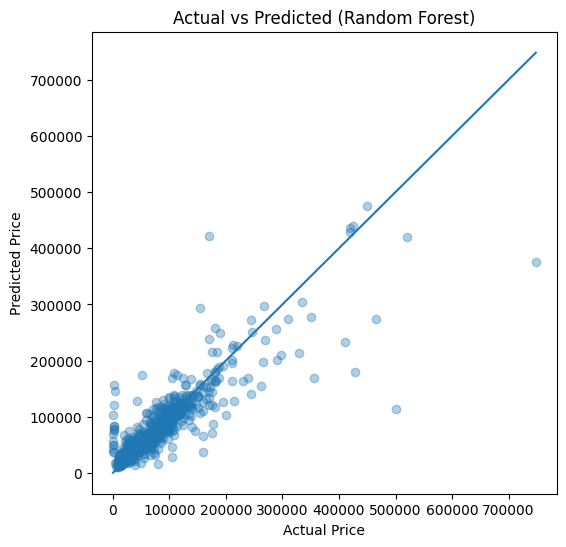

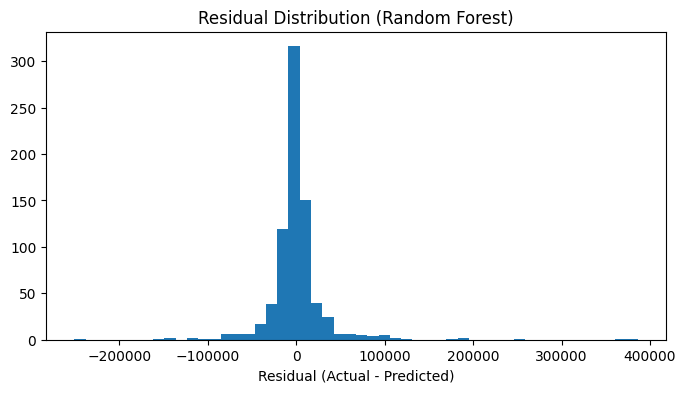

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, final_pred, alpha=0.35)
m = min(y_test.min(), final_pred.min())
M = max(y_test.max(), final_pred.max())
plt.plot([m, M], [m, M])
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Actual vs Predicted ({best_name})")
plt.show()

resid = y_test - final_pred
plt.figure(figsize=(8,4))
plt.hist(resid, bins=50)
plt.xlabel("Residual (Actual - Predicted)")
plt.title(f"Residual Distribution ({best_name})")
plt.show()


## Diagnostic Plot Interpretation

- **Actual vs Predicted Plot**: Titik yang mendekati garis diagonal menunjukkan prediksi yang akurat. Penyebaran yang lebih lebar pada harga tinggi dapat mengindikasikan adanya outlier atau kendaraan dengan karakteristik unik yang lebih sulit diprediksi.
- **Residual Distribution**: Residual yang terkonsentrasi di sekitar 0 menunjukkan model tidak terlalu bias (tidak selalu overestimate atau underestimate). Residual ekstrem yang jauh dari 0 biasanya terkait outlier atau kombinasi fitur yang jarang muncul.



## Conclusion & Recommendation

### Conclusion
Berdasarkan perbandingan tiga model (Linear Regression, Random Forest, dan HistGradientBoosting) menggunakan 5-Fold Cross Validation dengan metrik RMSE, model terbaik adalah **Random Forest** karena menghasilkan nilai CV_RMSE_mean terendah.  
Pada evaluasi data test, model Random Forest menunjukkan performa yang baik dengan MAE = 17,741.83, RMSE = 36,810.35, dan R² = 0.7434.

### Recommendation
Model Random Forest dapat digunakan sebagai dasar rekomendasi harga mobil bekas berdasarkan atribut kendaraan.

### Future Improvement (Opsional)
Beberapa langkah yang bisa dicoba untuk meningkatkan performa di masa depan:
- Penanganan outlier (misalnya pada `Price` atau `Mileage`) agar error pada nilai ekstrem berkurang.
- Transformasi target seperti `log(Price)` untuk membantu stabilisasi prediksi pada rentang harga tinggi.
- Menambah fitur baru jika tersedia (misalnya kondisi kendaraan, jumlah pemilik, tipe bahan bakar, dll).
- Hyperparameter tuning untuk mencari kombinasi parameter terbaik (belum dilakukan pada proyek ini).

